# Topological data analysis notebook

--------------------------------------------------------------------

*Author : Teresa Dalle Nogare
Version : 28 October 2023*

*TDA analysis of data normalized with standard scaler as Matteo Rucco did.*

--------------------------------------------------------------------

Data generated from simulations of the SIR epidemics on the simple lattice is stored in a dictionary built such that:
- key = timestep
- value = matrix with nodes per row, being composed by (x_node, y_node, #S, #I, #R)


In this notebook I take this dictionary of data and I provide it to the TDA machinary. 
The pipeline is based on the construction of persistence diagrams, from which the persistent entropy is calculated for each value of time. 

Two normalizations are considered in this notebook:
1. Normalization of data
2. Normalization of entropy

**POINT 1 - NORMALIZATION OF DATA**

In this notebook, the normalization calculated exploiting the function `Standard scaler` which implements a normalization with zero mean and unitary variance. 

In a previous version of the file, a normalization of both the position of nodes and the number of individuals is done separately. A problem could be that this normalization modifies the original shape of data and thus results of TDA. For this reason, attention must be kept in the normalization procedure to ensure that data are properly rescaled, but ensuring the shape of data to be preserved. The normalization step is necessary because if data differ of several orders of magnitude, it may be possible that the biggest component has the major weigth in the result of the TDA pipeline.

**POINT 2 - NORMALIZATION OF ENTROPY**

In [31]:
from functions_SIR_metapop import *

# Import and data management
import os
import pickle
import pandas as pd

# Scientific computing
import numpy as np
from sklearn.preprocessing import StandardScaler

# Topological data analysis
import ripser
from persim import plot_diagrams
from persim.persistent_entropy import *

# Plotting
import matplotlib.pyplot as plt


In [32]:
# Colors 
nbr_simulations = 10

grad_gray = []
grad_red = []
grad_blue = []
grad_green = []

for x in range(nbr_simulations):
    #                                dark           light
    grad_gray.append(colorFader('#505050', '#EAE9E9', x/nbr_simulations))
    grad_red.append(colorFader('#E51C00', '#FCE0DC', x/nbr_simulations))
    grad_blue.append(colorFader('#1D3ACE', '#C5CEFF', x/nbr_simulations))
    grad_green.append(colorFader('#0A8E1A', '#DAF7A6', x/nbr_simulations))

## DATA ACQUISITION

Acquire data for networks of different dimensions using data in the dictionary built with data obtained from the SIR simulations

In [33]:
def data_2_pandas(data_dict, scaled):
    """ Convert dictionary data in pandas dataframe. If scaled is True, then the Standard Scaler is used to scale 
    data. If scaled is False, data are not scaled but are maintained as the original ones.
    
    :param data_dict : dictionary of data from SIR simulation
    :param scaled : if True, scale data according to Standard Scaler
                    if False, do not scale data
                    
    :return : pandas dataframe 
    
    """
    frames = []  # List to hold individual dataframes
    
    for time, array in data_dict.items():
        N = len(array)  # Get the number of rows in the numpy array
        node_id = np.arange(1, N + 1)  # Generate Node ID sequence from 1 to N
        time_column = np.full((N,), time)  # Create a column filled with the current time value
    
        # Create a DataFrame
        df = pd.DataFrame({
            'Time': time_column,
            'Node ID': node_id,
            'X': array[:, 0],
            'Y': array[:, 1],
            'S': array[:, 2],
            'I': array[:, 3],
            'R': array[:, 4]
        })
    
        frames.append(df)
    
    # Concatenate all individual dataframes into one large DataFrame
    final_df = pd.concat(frames, ignore_index=True)
    if scaled:
        scaler = StandardScaler()
        final_df_standard = pd.DataFrame()
        
        final_df_standard = pd.DataFrame(scaler.fit_transform(final_df[["X","Y","S","I","R"]]),columns = ["X","Y","S","I","R"])
        final_df_standard["Time"] = final_df["Time"]
        final_df_standard["Node ID"] = final_df["Node ID"]
        
        return final_df_standard

    return final_df

In [34]:
def calculate_entropy_df(data_df, columns, normalize_entropy):

    time_inverval = range(data_df["Time"].min(), data_df["Time"].max())
    
    entropy_h0 = []
    entropy_h1 = []
    
    for i in time_inverval:
        mask = data_df['Time'] == i
        extracted_data = data_df.loc[mask, columns].values
    
        dgms = ripser.ripser(extracted_data)['dgms']
        entropy = persistent_entropy(dgms, normalize = normalize_entropy)
        entropy_h0.append(entropy[0])
        entropy_h1.append(entropy[1])
    


    return entropy_h0, entropy_h1

In [35]:
# Parameters

# TO ACQUIRE DATA FOR 30X30 NETWORK
N_row = [10, 30]
N_col = [10, 30]

choice_bool = 0
datadir = os.getcwd()
c1 = 0  # for now

beta_outbreak = [0.4, 0.3, 0.9]
mu_outbreak = [0.2, 0.1, 0.1]

beta_no_outbreak = [0.35, 0.75]
mu_no_outbreak = [0.3, 0.6]


**Step of normalization of data**
- `data_df` : dataframe built from the original dictionary
- `data_normalized_df` : dataframe of normalized data according to the standard scaler method

**Step of calculation of persistent entropy**

**CASE 1: NO ENTROPY NORMALIZATION**
Persistent entropy is calculated for either cases: both non normalized data and normalized data.
Entropy, in this case, is not normalized

**CASE 2 : ENTROPY NORMALIZATION**
Persistent entropy is calculated for either cases: both non normalized data and normalized data.
Entropy, in this cse, is normalized according to the definition of normalization of the `persistent_entropy` function.

In [36]:
# Outbreak = 0 : no outbreak occurs 
# Outbreak = 1 : outbreak occurs

outbreak = 1

# Load data and convert them into pandas dataframes
for row, col in zip(N_row, N_col):
    N = row * col
    if outbreak == 0:
        beta_vals = beta_no_outbreak
        mu_vals = mu_no_outbreak
    elif outbreak == 1:
        beta_vals = beta_outbreak
        mu_vals = mu_outbreak
    for beta, mu in zip(beta_vals, mu_vals):
    
        folder_dict = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Dictionaries/'
        folder_norm_entropy = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/Normalized-entropy/'
        folder_no_norm_entropy = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/No-normalized-entropy/'


        for sim in range(nbr_simulations):
            print('row: ', row, 'col: ', col)
            print('beta: ', beta, 'mu: ', mu)
            print('sim: ', sim)
            # Load data
            dict_vals = pickle.load(open(folder_dict + f'No-normalized/dict_data-{row}x{col}-sim{sim}.pickle', 'rb'))
            # Convert in dataframe
            data_df = data_2_pandas(dict_vals, scaled = False)
            data_normalized_df = data_2_pandas(dict_vals, scaled = True)

            for normalize_entropy in [True, False]:
                print('normalize entropy: ', normalize_entropy)
                columns = [ 'S', 'I', 'R']
                print('columns: ', columns)
                # Calculate persistent entropy for non-normalized data
                entropyH0_df, entropyH1_df = calculate_entropy_df(data_df, columns, normalize_entropy)
                # Calculate persistent entropy for normalized data
                entropyH0_df_norm, entropyH1_df_norm = calculate_entropy_df(data_normalized_df, columns, normalize_entropy)

                if normalize_entropy == 0:
                    print('save no entropy normalized data')
                   # Save data of non-normalized data 
                    np.save(folder_no_norm_entropy + f'Entropy-SIR/entropy_H0-sim{sim}', entropyH0_df)
                    np.save(folder_no_norm_entropy + f'Entropy-SIR/entropy_H1-sim{sim}', entropyH1_df)
                    # Save data of normalized data 
                    np.save(folder_no_norm_entropy + f'Entropy-scaler-SIR/entropy_H0-sim{sim}', entropyH0_df_norm)
                    np.save(folder_no_norm_entropy + f'Entropy-scaler-SIR/entropy_H1-sim{sim}', entropyH1_df_norm)
                elif normalize_entropy == 1:
                    print('save entropy normalized data')
                    # Save data of non-normalized data 
                    np.save(folder_norm_entropy + f'Entropy-SIR/entropy_H0-sim{sim}', entropyH0_df)
                    np.save(folder_norm_entropy + f'Entropy-SIR/entropy_H1-sim{sim}', entropyH1_df)
                    # Save data of normalized data 
                    np.save(folder_norm_entropy + f'Entropy-scaler-SIR/entropy_H0-sim{sim}', entropyH0_df_norm)
                    np.save(folder_norm_entropy + f'Entropy-scaler-SIR/entropy_H1-sim{sim}', entropyH1_df_norm)

row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  0
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  1
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  2
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  3
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  4
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  5
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  6
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  7
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  8
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.4 mu:  0.2
sim:  9
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  0
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  1
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  2
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  3
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  4
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  5
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  6
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  7
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  8
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.3 mu:  0.1
sim:  9
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  0
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  1
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  2
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  3
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  4
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  5
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  6
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  7
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  8
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  10 col:  10
beta:  0.9 mu:  0.1
sim:  9
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  0
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  1
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  2
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  3
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: invalid value encountered in scalar divide
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/an

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  4
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  5
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  6
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  7
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  8
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: invalid value encountered in scalar divide
  E = E / np.log(len(l))
/opt/an

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.4 mu:  0.2
sim:  9
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  0
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: invalid value encountered in scalar divide
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: invalid value encountered in scalar divide
  E = E / np.log(len(l))


save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  1
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  2
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  3
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  4
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  5
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  6
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  7
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  8
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.3 mu:  0.1
sim:  9
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  0
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  1
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  2
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  3
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  4
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  5
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  6
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  7
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  8
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data
row:  30 col:  30
beta:  0.9 mu:  0.1
sim:  9
normalize entropy:  True
columns:  ['S', 'I', 'R']


/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/envs/EpiNet/lib/python3.10/site-packages/persim/persistent_entropy.py:85: RuntimeWarning: divide by zero encountered in log
  E = E / np.log(len(l))
/opt/anaconda3/e

save entropy normalized data
normalize entropy:  False
columns:  ['S', 'I', 'R']
save no entropy normalized data


## DATA ANALYSIS

Plot persistent entropy results obtained before

In [37]:
def plot_entropy_time_series(entropy_h0, entropy_h1, beta, mu, sim, scaler, normalize_entropy):
    y_h0 = entropy_h0
    y_h1 = entropy_h1
    x = range(0,len(y_h0))
    
    fig, ax = plt.subplots()
    ax.plot(x, y_h0, label='Persistent entropy at H0')
    ax.plot(x, y_h1, label='Persistent entropy at H1')
    ax.set_xlabel("Time")
    ax.set_ylabel("Persistent Entropy")
    if normalize_entropy == 0:
        if scaler == 0:  
            ax.set_title(f"PE beta: {beta}, mu: {mu} - sim: {sim} ")
        elif scaler == 1:
            ax.set_title(f"PE beta: {beta}, mu: {mu} - sim: {sim} - scaled data")
    elif normalize_entropy == 1:
        if scaler == 0:
             ax.set_title(f"Normalized PE beta: {beta}, mu: {mu} - sim: {sim} ")
        elif scaler == 1:
            ax.set_title(f"Normalized PE beta: {beta}, mu: {mu} - sim: {sim} - scaled data")
    ax.legend()
    plt.show()

    

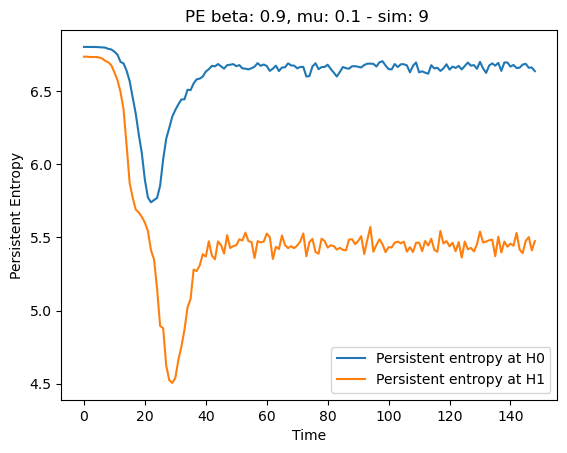

In [21]:
# Select data to load

row = 30
col = 30

beta = 0.9
mu = 0.1

sim = 9

scaler = 0
normalize_entropy = 0


for id in ['S', 'I', 'R']:
    if normalize_entropy == 0:
        folder = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/No-normalized-entropy/'
        if scaler == 0:
            entropy_h0 = np.load(folder + f'/Entropy-XY{id}/entropy_H0-sim{sim}.npy')
            entropy_h1 = np.load(folder + f'/Entropy-XY{id}/entropy_H1-sim{sim}.npy')
        elif scaler == 1:
            entropy_h0 = np.load(folder + f'/Entropy-scaler-XY{id}/entropy_H0-sim{sim}.npy')
            entropy_h1 = np.load(folder + f'/Entropy-scaler-XY{id}/entropy_H1-sim{sim}.npy')
    elif normalize_entropy == 1:
        folder= datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/Normalized-entropy/'
        if scaler == 0:
            entropy_h0 = np.load(folder + f'/Entropy-XY{id}/entropy_H0-sim{sim}.npy')
            entropy_h1 = np.load(folder + f'/Entropy-XY{id}/entropy_H1-sim{sim}.npy')
        elif scaler == 1:
            entropy_h0 = np.load(folder + f'/Entropy-scaler-XY{id}/entropy_H0-sim{sim}.npy')
            entropy_h1 = np.load(folder + f'/Entropy-scaler-XY{id}/entropy_H1-sim{sim}.npy')



plot_entropy_time_series(entropy_h0, entropy_h1, beta, mu, sim, scaler, normalize_entropy)

             


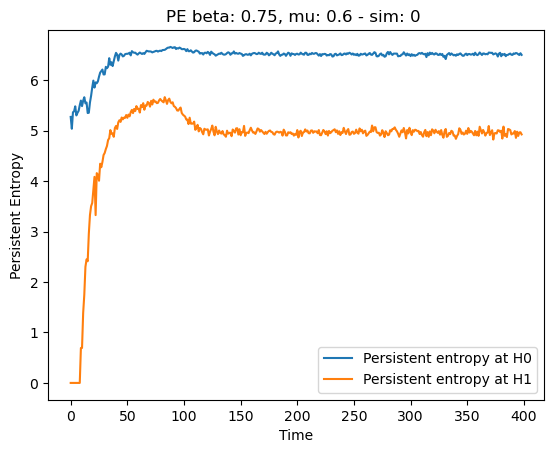

In [42]:
id = 'SIR'
row = 30
col = 30
beta = 0.75
mu = 0.6
scaler = 0
normalize_entropy = 0
sim = 0
if normalize_entropy == 0:
    folder = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/No-normalized-entropy/'
    if scaler == 0:
        entropy_h0 = np.load(folder + f'/Entropy-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-{id}/entropy_H1-sim{sim}.npy')
    elif scaler == 1:
        entropy_h0 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H1-sim{sim}.npy')
elif normalize_entropy == 1:
    folder= datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/Normalized-entropy/'
    if scaler == 0:
        entropy_h0 = np.load(folder + f'/Entropy-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-{id}/entropy_H1-sim{sim}.npy')
    elif scaler == 1:
        entropy_h0 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H1-sim{sim}.npy')
        
plot_entropy_time_series(entropy_h0, entropy_h1, beta, mu, sim, scaler, normalize_entropy)

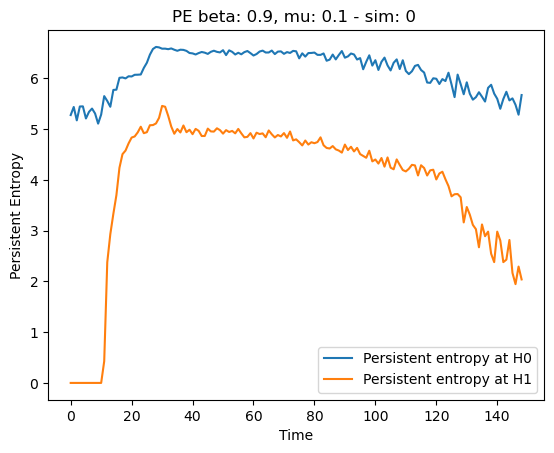

In [53]:
id = 'SIR'
row = 30
col = 30
beta = 0.9
mu = 0.1
sim = 0
scaler = 0
normalize_entropy = 0

if normalize_entropy == 0:
    folder = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/No-normalized-entropy/'
    if scaler == 0:
        entropy_h0 = np.load(folder + f'/Entropy-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-{id}/entropy_H1-sim{sim}.npy')
    elif scaler == 1:
        entropy_h0 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H1-sim{sim}.npy')
elif normalize_entropy == 1:
    folder= datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Analysis-notebook-TDA/Normalized-entropy/'
    if scaler == 0:
        entropy_h0 = np.load(folder + f'/Entropy-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-{id}/entropy_H1-sim{sim}.npy')
    elif scaler == 1:
        entropy_h0 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H0-sim{sim}.npy')
        entropy_h1 = np.load(folder + f'/Entropy-scaler-{id}/entropy_H1-sim{sim}.npy')
        
plot_entropy_time_series(entropy_h0, entropy_h1, beta, mu, sim, scaler, normalize_entropy)

In [61]:
row = 30
col = 30
beta = 0.9
mu = 0.1
sim = 0

folder_dict = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Dictionaries/'
dict_vals = pickle.load(open(folder_dict + f'No-normalized/dict_data-{row}x{col}-sim{sim}.pickle', 'rb'))
            # Convert in dataframe
data_df = data_2_pandas(dict_vals, scaled = False)

data_df.head(15)

,Time,Node ID,X,Y,S,I,R
0,0,1,0.0,0.0,9939.0,1.0,0.0
1,0,2,0.0,1.0,10021.0,0.0,0.0
2,0,3,0.0,2.0,9837.0,0.0,0.0
3,0,4,0.0,3.0,10017.0,0.0,0.0
4,0,5,0.0,4.0,10049.0,0.0,0.0
5,0,6,0.0,5.0,9978.0,0.0,0.0
6,0,7,0.0,6.0,9899.0,0.0,0.0
7,0,8,0.0,7.0,9839.0,0.0,0.0
8,0,9,0.0,8.0,10030.0,0.0,0.0
9,0,10,0.0,9.0,9888.0,0.0,0.0


In [58]:
x = range(0,len(entropy_h0))
np.array(x)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148])

In [50]:
entropy_h1

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.42730306,  2.37649387,  2.92966607,  3.33071208,
        3.69865704,  4.23808797,  4.50670363,  4.5776964 ,  4.71900922,
        4.83383193,  4.85552998,  4.93571103,  5.04727085,  4.92007344,
        4.93979419,  5.07646353,  5.07999944,  5.11201909,  5.22165682,
        5.45695752,  5.44066462,  5.26189326,  5.05154002,  4.9091127 ,
        5.00186376,  4.93427278,  5.07171102,  4.93899864,  4.98802569,
        4.90027794,  5.00464747,  4.9660378 ,  4.86447819,  4.86473986,
        5.00993793,  4.95499973,  4.95128223,  5.01630525,  4.98013769,
        4.91106799,  4.98018523,  4.94333961,  4.96455416,  4.91703122,
        5.00367176,  4.91684354,  4.83814754,  4.8476413 ,  4.92095227,
        4.81621993,  4.92927025,  4.90315396,  4.91594641,  4.8397542 ,
        4.97365178,  4.89806813,  4.83607269,  4.88407519,  4.85

In [66]:
from mpl_toolkits.mplot3d import Axes3D
# Plot pandas dataframes in phase space
def plot_phase_space_df(data_df, id):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pnt3d = ax.scatter3D(data_df['X'],data_df['Y'], data_df[f'{id}'])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel(f'{id}')
plt.show()

In [79]:
#RESTART FROM SIM 4
outbreak = 0

row = 10
col = 10

sim = 0

if outbreak == 0:
    beta_vals = beta_no_outbreak
    mu_vals = mu_no_outbreak
elif outbreak == 1:
    beta_vals = beta_outbreak
    mu_vals = mu_outbreak
for beta, mu in zip(beta_vals, mu_vals):
    
    folder_dict = datadir + f'/Data-simpleLattice/{row}x{col}/choice_bool-{choice_bool}/c1-{int(np.floor(c1))}/Simulations/beta-{beta}mu-{mu}/Dictionaries/'
    dict_vals = pickle.load(open(folder_dict + f'No-normalized/dict_data-{row}x{col}-sim{sim}.pickle', 'rb'))
    # Convert in dataframe
    data_df = data_2_pandas(dict_vals, scaled = False)
    data_normalized_df = data_2_pandas(dict_vals, scaled = True)

            

In [80]:
data_df.head()

,Time,Node ID,X,Y,S,I,R
0,0,1,0.0,0.0,10049.0,8.0,0.0
1,0,2,0.0,1.0,10022.0,0.0,0.0
2,0,3,0.0,2.0,10087.0,0.0,0.0
3,0,4,0.0,3.0,10106.0,0.0,0.0
4,0,5,0.0,4.0,10163.0,0.0,0.0


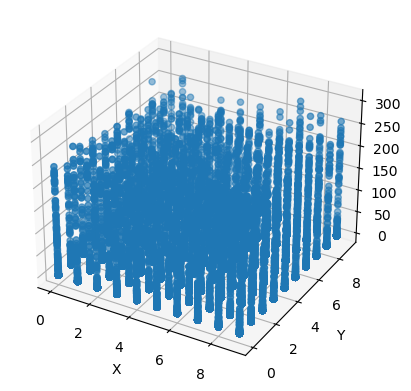

In [81]:
plot_phase_space_df(data_df, 'I')

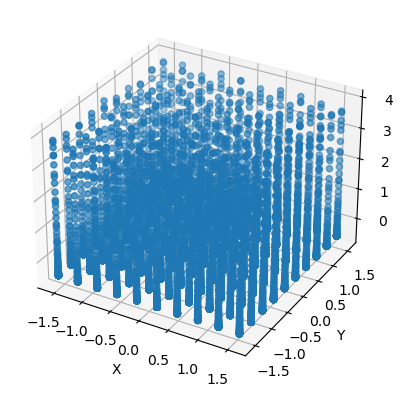

In [78]:
plot_phase_space_df(data_normalized_df, 'I')